## Token Analysis 
Some analysis about the words found in the verdicts. 
This might help to decide which type of tokenization I need to use to create a scalable and robust summarization system.

Assumption: When executing this notebook, we are in the "analysis" folder, to have the ability to use relative paths.

### Data Loading

In [1]:
from collections import Counter
import io
import os
import pickle
from pathlib import Path
import seaborn as sns
from pprint import pprint

In [2]:
with io.open(Path("..")/".."/"model"/"frequency.pkl", "rb") as f:
    counter = pickle.load(f)

In [3]:
counts = counter.values()
print("Range of token counts:", "[", min(counts),",", max(counts), "]")

Range of token counts: [ 1 , 12265497 ]


In [4]:
print("Most common words:")
pprint(counter.most_common(20))

Most common words:
[('der', 12265497),
 ('<num>', 10577608),
 ('die', 10112938),
 ('des', 4699633),
 ('und', 4220946),
 ('in', 3517945),
 ('nicht', 3391635),
 ('zu', 2906085),
 ('den', 2886045),
 ('<norm>', 2631495),
 ('ist', 2429422),
 ('von', 2409823),
 ('das', 2380290),
 ('dem', 2291145),
 ('auf', 2258733),
 ('dass', 2145865),
 ('im', 2090941),
 ('für', 2089969),
 ('eine', 1970709),
 ('mit', 1875704)]


In [5]:
print("Number of uniqe words:", len(counter))

Number of uniqe words: 1078009


In [6]:
frequency_count = Counter(counts)
print("Most common number of occurences of unique words:")
pprint(frequency_count.most_common(20))

Most common number of occurences of unique words:
[(1, 442233),
 (2, 165160),
 (3, 79268),
 (4, 53786),
 (5, 35276),
 (6, 27969),
 (7, 21188),
 (8, 17585),
 (9, 14295),
 (10, 12652),
 (11, 10637),
 (12, 9340),
 (13, 8239),
 (14, 7496),
 (15, 6481),
 (16, 6017),
 (17, 5432),
 (18, 5018),
 (19, 4541),
 (20, 4284)]


Based on the very large portion of unique words, which only appear a handful of times, we need to set a token count threshold. Otherwise the number of tokens will be way to large for learning.

In [7]:
threshold = 100
filtered_counts = list(filter(lambda x: x > threshold, counts))
print("Number of unique words (after threshold filter):", len(filtered_counts))
print("Percentage of total words cut:", (1-sum(filtered_counts)/sum(counts)))

Number of unique words (after threshold filter): 54139
Percentage of total words cut: 0.027985444213289745


Percentage of individual word occurences:


<AxesSubplot:ylabel='Density'>

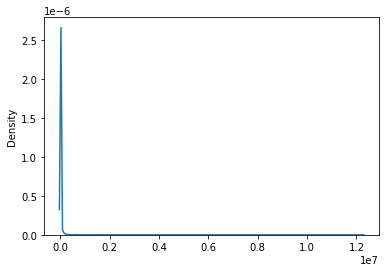

In [8]:
print("Percentage of individual word occurences:")
sns.kdeplot(filtered_counts)

In [9]:
# TODO do plot of threshold vs percentage of total words cut

### Result
The tokenization should probably be build around byte-pair encoding, otherwise is the number of unique words just way to high. A high threshold might be an Option, as only a small portion of the verdict would be replaced with "\<unk\>"
On the other hand, only 3% of words are cut, if we only allow tokens with a high occurence number. I.e. it will not be problematic to just remove them.

## Guiding Principle Analysis
I will have a look at general properties for the Guiding Principles. E.g. number of sentences, len

In [10]:
import sys
sys.path.append("..")
from tqdm import tqdm
from functools import reduce

from preprocessing import Tokenizer
DATA_PATH = Path("..")/".."/"data"/"dataset"


In [11]:
gps = []
tok = Tokenizer(Path("..")/".."/"model")
for file in tqdm(os.listdir(DATA_PATH), desc="Tokenizing:"):
    verdict = tok.tokenize_verdict(DATA_PATH/file)
    gps.append(verdict["guiding_principle"])

Tokenizing:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100018/100018 [19:57<00:00, 83.49it/s]


In [12]:
gp_lengths = list(map(lambda sentences: list(map(lambda sentence: len(sentence),sentences)),gps))
all_lengths = reduce(lambda x, y: x+y, gp_lengths)
average = sum(all_lengths)/len(all_lengths)
print("Average guiding principle length:", average)

Average guiding principle length: 25.820362674726105


In [13]:
print("Lenghts in : [", min(all_lengths), ",", max(all_lengths), "]")
print("Total num tokens:", sum(all_lengths))

Lenghts in : [ 1 , 276 ]
Total num tokens: 7518115


<AxesSubplot:ylabel='Density'>

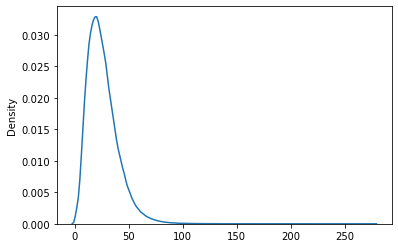

In [14]:
sns.kdeplot(all_lengths)

In [15]:
num_gps = list(map(lambda gps: len(gps), gp_lengths))
sent_average = sum(num_gps)/len(num_gps)
print("Average number of gp sentences:", sent_average)

Average number of gp sentences: 2.911175988322102


In [16]:
print("Lenghts in : [", min(num_gps), ",", max(num_gps), "]")
print("Total num tokens:", sum(num_gps))

Lenghts in : [ 1 , 74 ]
Total num tokens: 291170


ATTENTION: We have to filter the guiding principles after tokenization as well, otherwise there might be an empty verdict!

<AxesSubplot:ylabel='Density'>

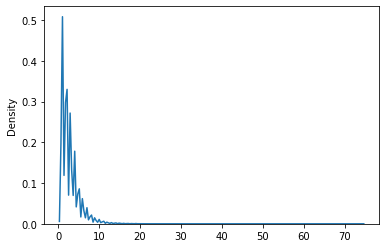

In [17]:
sns.kdeplot(num_gps)

## Text Analyis
We want to have a general look into the lengths of the documents. First, we have a look at the number of tokens per sentence in the different regions.

In [19]:
lengths = []
tok = Tokenizer(Path("..")/".."/"model")
for file in tqdm(os.listdir(DATA_PATH), desc="Tokenizing:"):
    verdict = tok.tokenize_verdict(DATA_PATH/file)
    gp_lengths = []
    for g in verdict["guiding_principle"]:
        gp_lengths.append(len(g))
    f_lengths = []
    for f in verdict["facts"]:
        f_lengths.append(len(f))
    r_lengths = []
    for r in verdict["reasoning"]:
        r_lengths.append(len(r))
    lengths.append((gp_lengths, f_lengths, r_lengths))

Tokenizing:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100018/100018 [20:09<00:00, 82.67it/s]


In [20]:
gp_lengths = []
f_lengths = []
r_lengths = []
for gp, f, r in lengths:
    gp_lengths.append(gp)
    f_lengths.append(f)
    r_lengths.append(r)

### Tokens in Guiding Principle

In [21]:
all_lengths = [j for i in gp_lengths for j in i]

In [22]:
average = sum(all_lengths)/len(all_lengths)
print("Average guiding principle length:", average)

Average guiding principle length: 25.820362674726105


In [23]:
print("Lenghts in : [", min(all_lengths), ",", max(all_lengths), "]")
print("Total num tokens:", sum(all_lengths))

Lenghts in : [ 1 , 276 ]
Total num tokens: 7518115


<AxesSubplot:ylabel='Density'>

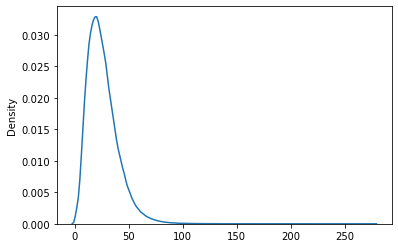

In [24]:
sns.kdeplot(all_lengths)

### Tokens in Facts

In [25]:
all_lengths = [j for i in f_lengths for j in i]

In [26]:
average = sum(all_lengths)/len(all_lengths)
print("Average facts length:", average)

Average facts length: 19.310186486636958


In [27]:
print("Lenghts in : [", min(all_lengths), ",", max(all_lengths), "]")
print("Total num tokens:", sum(all_lengths))

Lenghts in : [ 1 , 1153 ]
Total num tokens: 70409053


<AxesSubplot:ylabel='Density'>

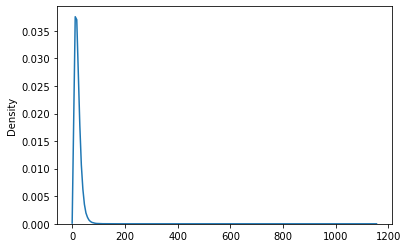

In [29]:
sns.kdeplot(all_lengths)

### Tokens in Reasoning

In [30]:
all_lengths = [j for i in r_lengths for j in i]

In [31]:
average = sum(all_lengths)/len(all_lengths)
print("Average reasoning length:", average)

Average reasoning length: 22.87609130468869


In [32]:
print("Lenghts in : [", min(all_lengths), ",", max(all_lengths), "]")
print("Total num tokens:", sum(all_lengths))

Lenghts in : [ 1 , 887 ]
Total num tokens: 171866038


<AxesSubplot:ylabel='Density'>

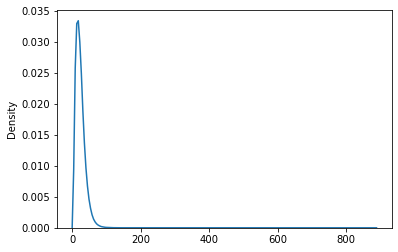

In [33]:
sns.kdeplot(all_lengths)

### Tokens in Body

In [34]:
body_length = []
for f, r in zip(f_lengths, r_lengths):
    body_length.append(f+r)

In [35]:
all_lengths = [j for i in body_length for j in i]

In [36]:
average = sum(all_lengths)/len(all_lengths)
print("Average body sentence length:", average)

Average body sentence length: 21.71094173700373


In [37]:
print("Lenghts in : [", min(all_lengths), ",", max(all_lengths), "]")
print("Total num tokens:", sum(all_lengths))

Lenghts in : [ 1 , 1153 ]
Total num tokens: 242275091


## Sentences

Now we will have a look at the number of sentences per segment.

In [38]:
gp_lengths = []
f_lengths = []
r_lengths = []
for gp, f, r in lengths:
    gp_lengths.append(len(gp))
    f_lengths.append(len(f))
    r_lengths.append(len(r))

### Sentences in Guiding Principles

In [39]:
average = sum(gp_lengths)/len(gp_lengths)
print("Average num sentences in guiding principle:", average)

Average num sentences in guiding principle: 2.911175988322102


In [40]:
print("Lenghts in : [", min(gp_lengths), ",", max(gp_lengths), "]")
print("Total num sentences:", sum(gp_lengths))

Lenghts in : [ 1 , 74 ]
Total num sentences: 291170


<AxesSubplot:ylabel='Density'>

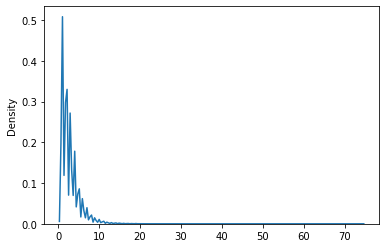

In [41]:
sns.kdeplot(gp_lengths)

### Sentences in Facts

In [42]:
average = sum(f_lengths)/len(f_lengths)
print("Average num sentences in facts:", average)

Average num sentences in facts: 36.455567997760404


In [43]:
print("Lenghts in : [", min(f_lengths), ",", max(f_lengths), "]")
print("Total num sentences:", sum(f_lengths))

Lenghts in : [ 0 , 1693 ]
Total num sentences: 3646213


<AxesSubplot:ylabel='Density'>

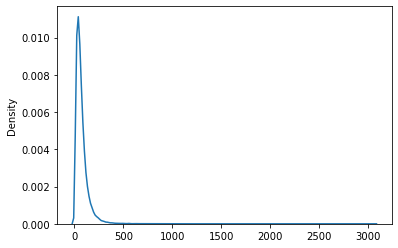

In [44]:
sns.kdeplot(r_lengths)

### Sentences in Reasoning

In [45]:
average = sum(r_lengths)/len(r_lengths)
print("Average num sentences in reasoning:", average)

Average num sentences in reasoning: 75.11558919394508


In [46]:
print("Lenghts in : [", min(r_lengths), ",", max(r_lengths), "]")
print("Total num sentences:", sum(r_lengths))

Lenghts in : [ 0 , 3063 ]
Total num sentences: 7512911


<AxesSubplot:ylabel='Density'>

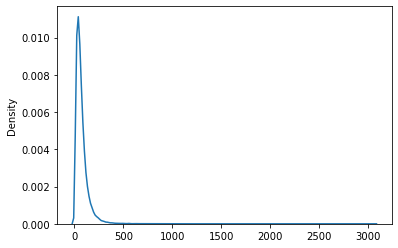

In [47]:
sns.kdeplot(r_lengths)

### Sentences in total Body

In [48]:
body_length = []
for f, r in zip(f_lengths, r_lengths):
    body_length.append(f+r)

In [49]:
average = sum(body_length)/len(body_length)
print("Average num sentences in body:", average)

Average num sentences in body: 111.5711571917055


In [50]:
print("Lenghts in : [", min(body_length), ",", max(body_length), "]")
print("Total num sentences:", sum(body_length))

Lenghts in : [ 1 , 3063 ]
Total num sentences: 11159124


<AxesSubplot:ylabel='Density'>

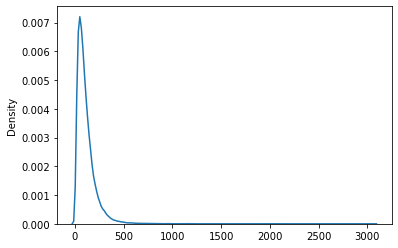

In [51]:
sns.kdeplot(body_length)